<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 16.2 MB/s eta 0:00:00


In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

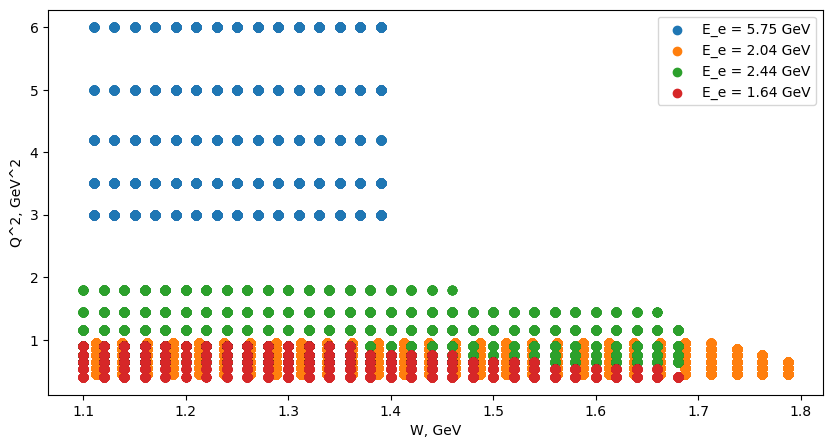

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [8]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="7.4 Loss Function: Quantile Loss")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, target):
        quantile = 0.5  #Quantile should be in (0, 1) range
        errors = target - preds
        loss = torch.max((quantile - 1) * errors, quantile * errors)
        return torch.abs(loss).mean()

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': StandardScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': False,
    'augment_factor': 5,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': QuantileLoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 30,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [10]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2025-01-29 08:03:51,908 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2025-01-29 08:03:51,920 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-01-29 08:03:51,927 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-01-29 08:03:51,938 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | QuantileLoss        | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2025-01-29 08:03:53,686 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | QuantileLoss        | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2025-01-29 08:03:53,716 : INFO : Training is starting
2025-01-29 08:05:01,452 : INFO : epoch: 0; val_loss: 0.012891950085759163
202

INFO: Metric val_loss improved. New best score: 0.013


2025-01-29 08:05:01,479 : INFO : Metric val_loss improved. New best score: 0.013
2025-01-29 08:05:01,630 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01289-epoch=00.ckpt
2025-01-29 08:06:07,082 : INFO : epoch: 1; val_loss: 0.01292283646762371
2025-01-29 08:06:07,087 : INFO : epoch: 1; train_loss: 0.012794903479516506
2025-01-29 08:06:07,201 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01292-epoch=01.ckpt
2025-01-29 08:07:27,247 : INFO : epoch: 2; val_loss: 0.01286616362631321
2025-01-29 08:07:27,255 : INFO : epoch: 2; train_loss: 0.012823843397200108


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


2025-01-29 08:07:27,274 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013
2025-01-29 08:07:27,399 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01287-epoch=02.ckpt
2025-01-29 08:08:44,400 : INFO : epoch: 3; val_loss: 0.01288127712905407
2025-01-29 08:08:44,407 : INFO : epoch: 3; train_loss: 0.012819350697100163
2025-01-29 08:08:44,531 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01288-epoch=03.ckpt
2025-01-29 08:09:59,283 : INFO : epoch: 4; val_loss: 0.012863279320299625
2025-01-29 08:09:59,288 : INFO : epoch: 4; train_loss: 0.012843762524425983
2025-01-29 08:09:59,393 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01286-epoch=04.ckpt
2025-

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.012


2025-01-29 08:11:12,718 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.012
2025-01-29 08:11:12,810 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.01194-epoch=05.ckpt
2025-01-29 08:12:29,628 : INFO : epoch: 6; val_loss: 0.004791394341737032
2025-01-29 08:12:29,636 : INFO : epoch: 6; train_loss: 0.006834983825683594


INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.005


2025-01-29 08:12:29,672 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.005
2025-01-29 08:12:29,764 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00479-epoch=06.ckpt
2025-01-29 08:13:59,577 : INFO : epoch: 7; val_loss: 0.005092168226838112
2025-01-29 08:13:59,587 : INFO : epoch: 7; train_loss: 0.004518745467066765
2025-01-29 08:13:59,699 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00509-epoch=07.ckpt
2025-01-29 08:15:25,223 : INFO : epoch: 8; val_loss: 0.003703832160681486
2025-01-29 08:15:25,230 : INFO : epoch: 8; train_loss: 0.003968054428696632


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.004


2025-01-29 08:15:25,250 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.004
2025-01-29 08:15:25,329 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00370-epoch=08.ckpt
2025-01-29 08:16:46,773 : INFO : epoch: 9; val_loss: 0.0036944823805242777
2025-01-29 08:16:46,779 : INFO : epoch: 9; train_loss: 0.0036206499207764864
2025-01-29 08:16:46,865 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00369-epoch=09.ckpt
2025-01-29 08:18:07,774 : INFO : epoch: 10; val_loss: 0.003241629106923938
2025-01-29 08:18:07,780 : INFO : epoch: 10; train_loss: 0.003497083205729723


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:18:07,805 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:18:07,905 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00324-epoch=10.ckpt
2025-01-29 08:19:28,597 : INFO : epoch: 11; val_loss: 0.0034479498863220215
2025-01-29 08:19:28,604 : INFO : epoch: 11; train_loss: 0.0033843573182821274
2025-01-29 08:19:28,701 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00345-epoch=11.ckpt
2025-01-29 08:20:50,084 : INFO : epoch: 12; val_loss: 0.003172776661813259
2025-01-29 08:20:50,091 : INFO : epoch: 12; train_loss: 0.0033487100154161453


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:20:50,126 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:20:50,256 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00317-epoch=12.ckpt
2025-01-29 08:22:15,032 : INFO : epoch: 13; val_loss: 0.003127448260784149
2025-01-29 08:22:15,038 : INFO : epoch: 13; train_loss: 0.003296646988019347


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:22:15,060 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:22:15,220 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00313-epoch=13.ckpt
2025-01-29 08:23:42,170 : INFO : epoch: 14; val_loss: 0.00338868354447186
2025-01-29 08:23:42,176 : INFO : epoch: 14; train_loss: 0.0032299761660397053
2025-01-29 08:25:12,874 : INFO : epoch: 15; val_loss: 0.0032774191349744797
2025-01-29 08:25:12,886 : INFO : epoch: 15; train_loss: 0.0031964771915227175
2025-01-29 08:26:41,316 : INFO : epoch: 16; val_loss: 0.0029682309832423925
2025-01-29 08:26:41,323 : INFO : epoch: 16; train_loss: 0.0031319160480052233


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:26:41,345 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:26:41,587 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00297-epoch=16.ckpt
2025-01-29 08:28:07,080 : INFO : epoch: 17; val_loss: 0.003177081700414419
2025-01-29 08:28:07,087 : INFO : epoch: 17; train_loss: 0.0031080867629498243
2025-01-29 08:29:37,044 : INFO : epoch: 18; val_loss: 0.0029378144536167383
2025-01-29 08:29:37,049 : INFO : epoch: 18; train_loss: 0.003097405657172203


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:29:37,069 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:29:37,173 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00294-epoch=18.ckpt
2025-01-29 08:31:00,578 : INFO : epoch: 19; val_loss: 0.0030903061851859093
2025-01-29 08:31:00,585 : INFO : epoch: 19; train_loss: 0.003056800225749612
2025-01-29 08:31:00,687 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00309-epoch=19.ckpt
2025-01-29 08:32:25,984 : INFO : epoch: 20; val_loss: 0.003170532640069723
2025-01-29 08:32:25,989 : INFO : epoch: 20; train_loss: 0.0030661688651889563
2025-01-29 08:33:49,506 : INFO : epoch: 21; val_loss: 0.0033382035326212645
2025-01-29 08:33:49,513 : INFO : epoch: 21; train_loss: 0.0030335893388837576
2025-01-29 08:35:13,973 : INFO : epoch:

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:36:39,129 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:36:39,198 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00287-epoch=23.ckpt
2025-01-29 08:38:04,951 : INFO : epoch: 24; val_loss: 0.002890325151383877
2025-01-29 08:38:04,958 : INFO : epoch: 24; train_loss: 0.0029176194220781326
2025-01-29 08:38:05,064 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00289-epoch=24.ckpt
2025-01-29 08:39:32,919 : INFO : epoch: 25; val_loss: 0.00292059569619596
2025-01-29 08:39:32,929 : INFO : epoch: 25; train_loss: 0.002891519805416465
2025-01-29 08:39:33,077 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00292-epoch=25.ckpt


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:40:59,012 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:40:59,088 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00279-epoch=26.ckpt
2025-01-29 08:42:24,954 : INFO : epoch: 27; val_loss: 0.003051142208278179
2025-01-29 08:42:24,960 : INFO : epoch: 27; train_loss: 0.002896985039114952
2025-01-29 08:43:52,685 : INFO : epoch: 28; val_loss: 0.0029311596881598234
2025-01-29 08:43:52,690 : INFO : epoch: 28; train_loss: 0.00295429490506649
2025-01-29 08:45:18,995 : INFO : epoch: 29; val_loss: 0.0030047381296753883
2025-01-29 08:45:19,001 : INFO : epoch: 29; train_loss: 0.0029226532205939293
2025-01-29 08:46:44,446 : INFO : epoch: 30; val_loss: 0.002970015862956643
2025-01-29 08:46:44,452 : INFO : epoch: 30; train_loss: 0.0029056479688733816
2025-01-29 08:48:10,142 : INFO : epoch: 31; val_loss: 0.002820805413648486
2025-01-

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:49:37,163 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:49:37,354 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00278-epoch=32.ckpt
2025-01-29 08:51:02,282 : INFO : epoch: 33; val_loss: 0.0027856521774083376
2025-01-29 08:51:02,289 : INFO : epoch: 33; train_loss: 0.0028534885495901108
2025-01-29 08:51:02,396 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00279-epoch=33.ckpt
2025-01-29 08:52:27,504 : INFO : epoch: 34; val_loss: 0.0029575121589004993
2025-01-29 08:52:27,511 : INFO : epoch: 34; train_loss: 0.002876332262530923
2025-01-29 08:53:53,732 : INFO : epoch: 35; val_loss: 0.0028564126696437597
2025-01-29 08:53:53,739 : INFO : epoch: 35; train_loss: 0.0028628373984247446
2025-01-29 08:55:18,448 : INFO : epoch

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 08:59:29,824 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 08:59:29,931 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00276-epoch=39.ckpt
2025-01-29 09:00:55,788 : INFO : epoch: 40; val_loss: 0.0029155921656638384
2025-01-29 09:00:55,794 : INFO : epoch: 40; train_loss: 0.0028259861283004284
2025-01-29 09:02:20,383 : INFO : epoch: 41; val_loss: 0.0031132237054407597
2025-01-29 09:02:20,390 : INFO : epoch: 41; train_loss: 0.0028703638818114996
2025-01-29 09:03:44,994 : INFO : epoch: 42; val_loss: 0.0028355931863188744
2025-01-29 09:03:45,001 : INFO : epoch: 42; train_loss: 0.0028707922901958227
2025-01-29 09:05:10,249 : INFO : epoch: 43; val_loss: 0.0028279719408601522
2025-01-29 09:05:10,255 : INFO : epoch: 43; train_loss: 0.002838867949321866
2025-01-29 09:06:35,401 : INFO : epoch: 44; val_loss: 0.0027321060188114643
202

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 09:06:35,430 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 09:06:35,508 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00273-epoch=44.ckpt
2025-01-29 09:07:59,546 : INFO : epoch: 45; val_loss: 0.002738865790888667
2025-01-29 09:07:59,551 : INFO : epoch: 45; train_loss: 0.0027830074541270733
2025-01-29 09:07:59,650 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00274-epoch=45.ckpt
2025-01-29 09:09:23,173 : INFO : epoch: 46; val_loss: 0.0027338676154613495
2025-01-29 09:09:23,179 : INFO : epoch: 46; train_loss: 0.002764875767752528
2025-01-29 09:09:23,280 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00273-epoch=46.ckp

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


2025-01-29 09:31:08,701 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003
2025-01-29 09:31:08,828 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00271-epoch=61.ckpt
2025-01-29 09:32:37,129 : INFO : epoch: 62; val_loss: 0.0027213701978325844
2025-01-29 09:32:37,137 : INFO : epoch: 62; train_loss: 0.0027056115213781595
2025-01-29 09:32:37,271 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00272-epoch=62.ckpt
2025-01-29 09:34:03,871 : INFO : epoch: 63; val_loss: 0.002715302398428321
2025-01-29 09:34:03,877 : INFO : epoch: 63; train_loss: 0.0027007008902728558
2025-01-29 09:34:04,002 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.4 Loss Function: Quantile Loss/checkpoints/exp_name=0val_loss=0.00272-epoch=63.ck

INFO: Monitored metric val_loss did not improve in the last 30 records. Best score: 0.003. Signaling Trainer to stop.


2025-01-29 10:16:25,600 : INFO : Monitored metric val_loss did not improve in the last 30 records. Best score: 0.003. Signaling Trainer to stop.
2025-01-29 10:16:25,607 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [11]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [12]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:05<00:00, 26.28it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07836936286375397' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0028950765530147008' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

2025-01-29 10:29:37,668 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-01-29 10:29:37,672 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-29 10:29:37,676 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-29 10:29:37,679 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-29 10:29:37,681 : DEBUG : findfo

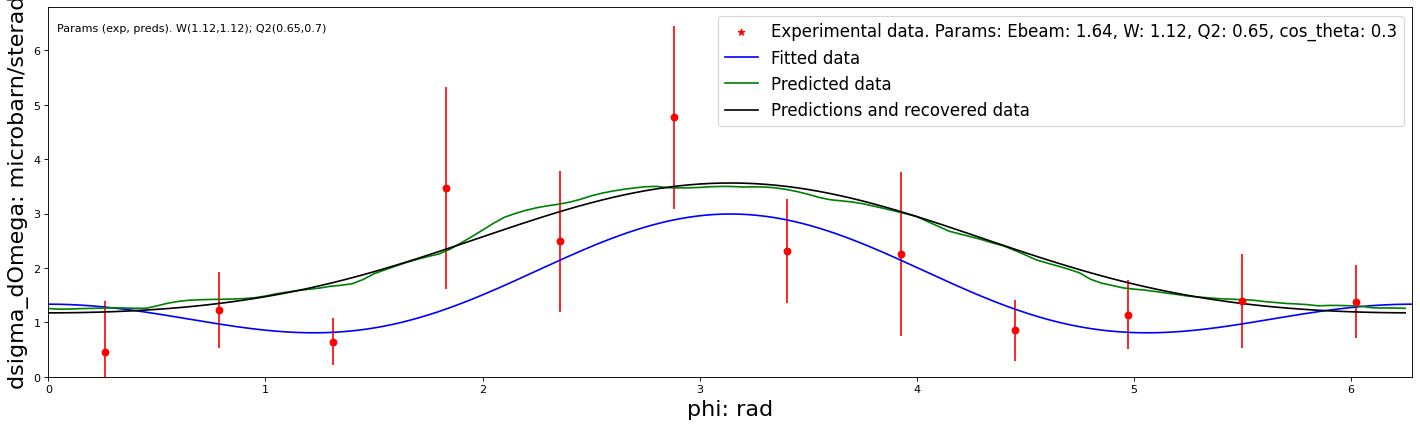

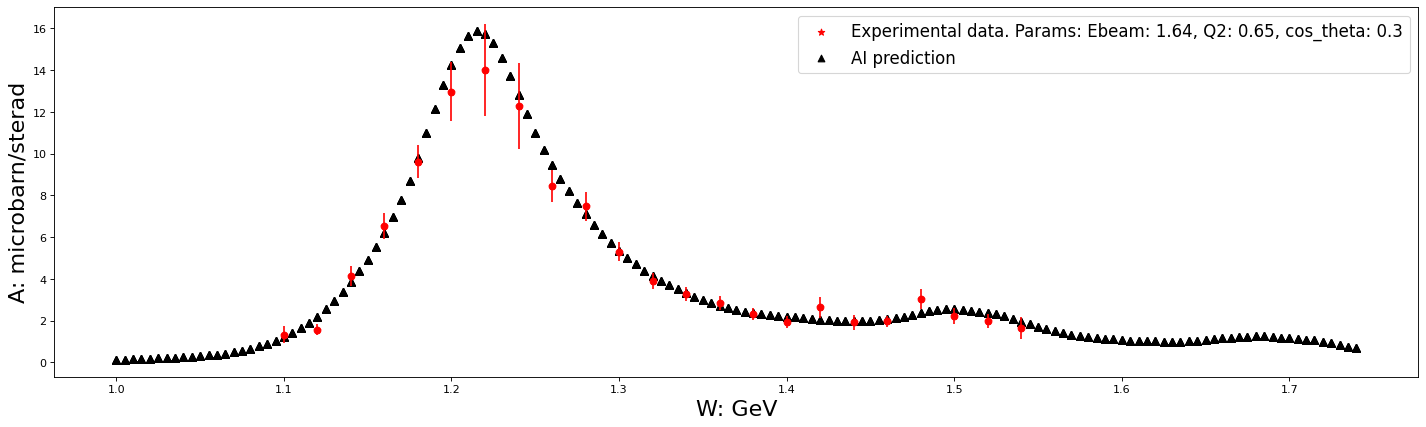

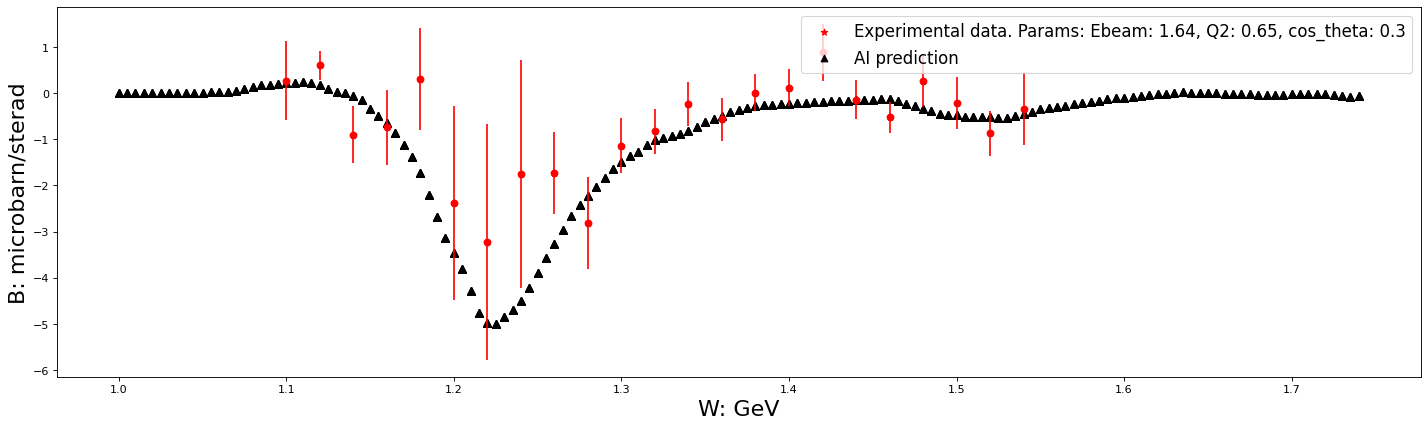

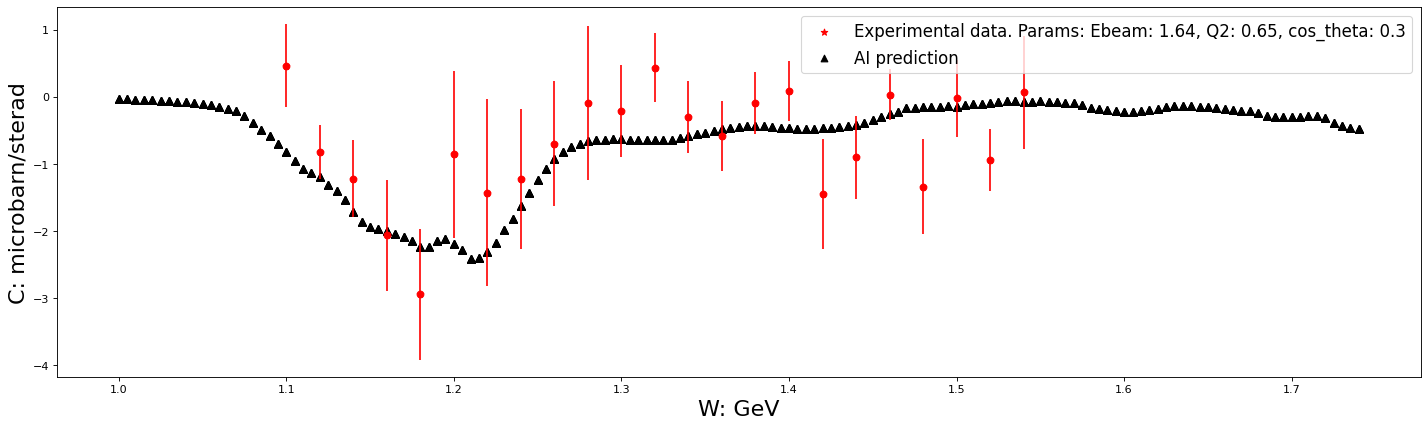

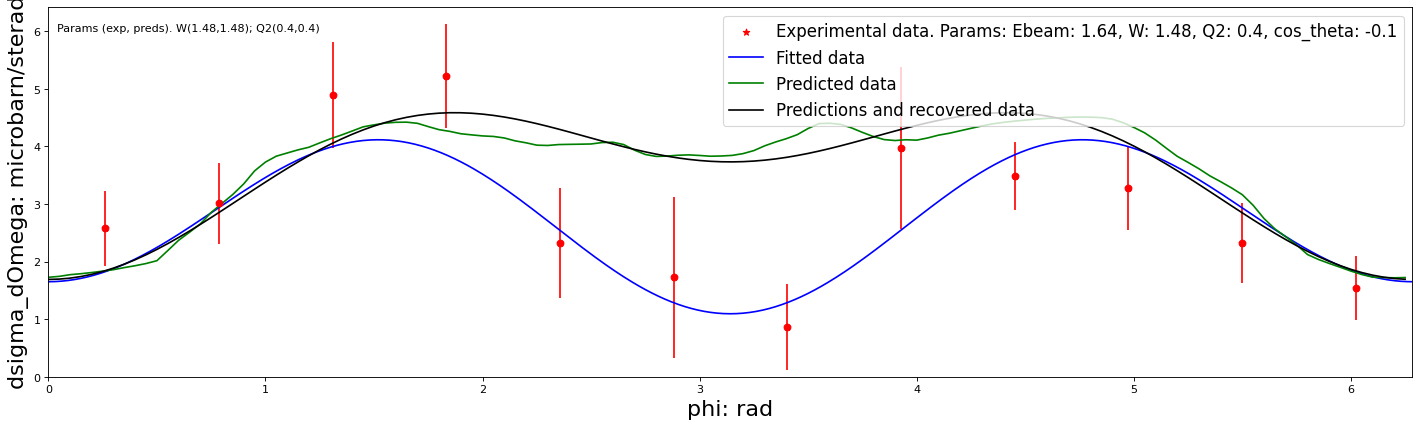

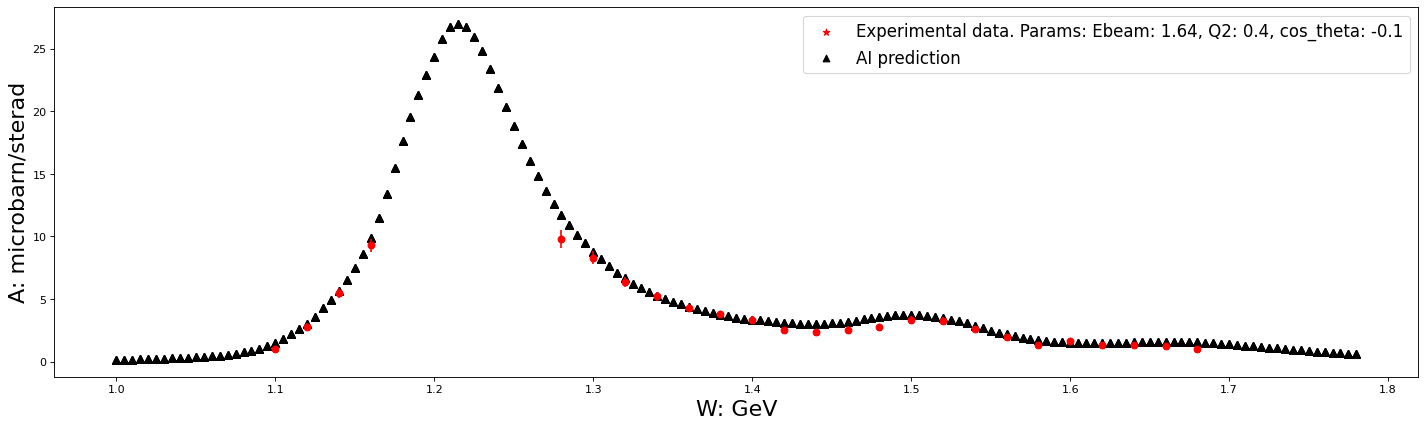

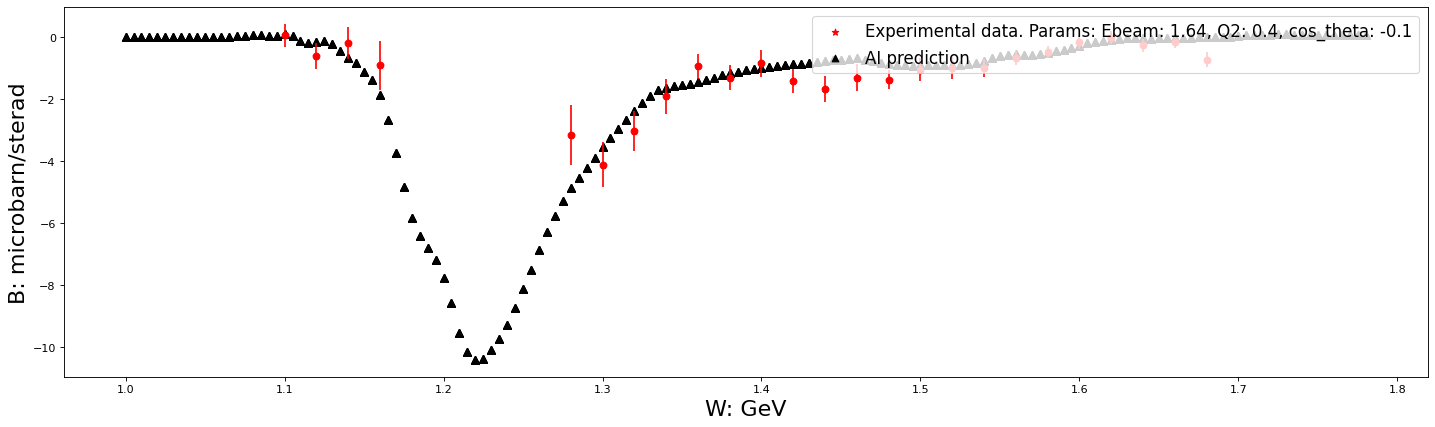

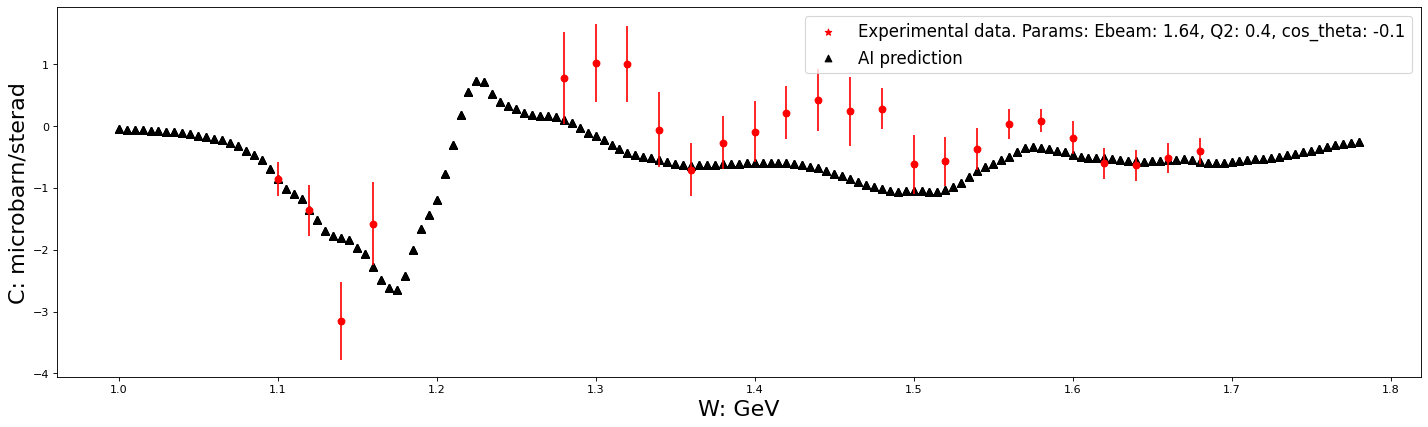

100%|██████████| 157/157 [00:06<00:00, 22.55it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05145191936781837' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00021082552287746638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython

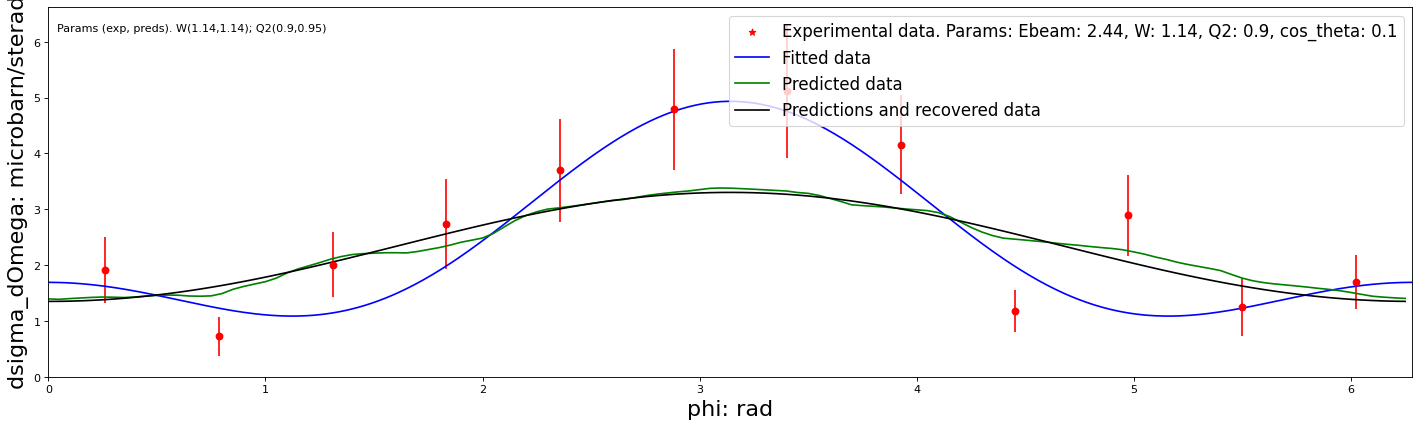

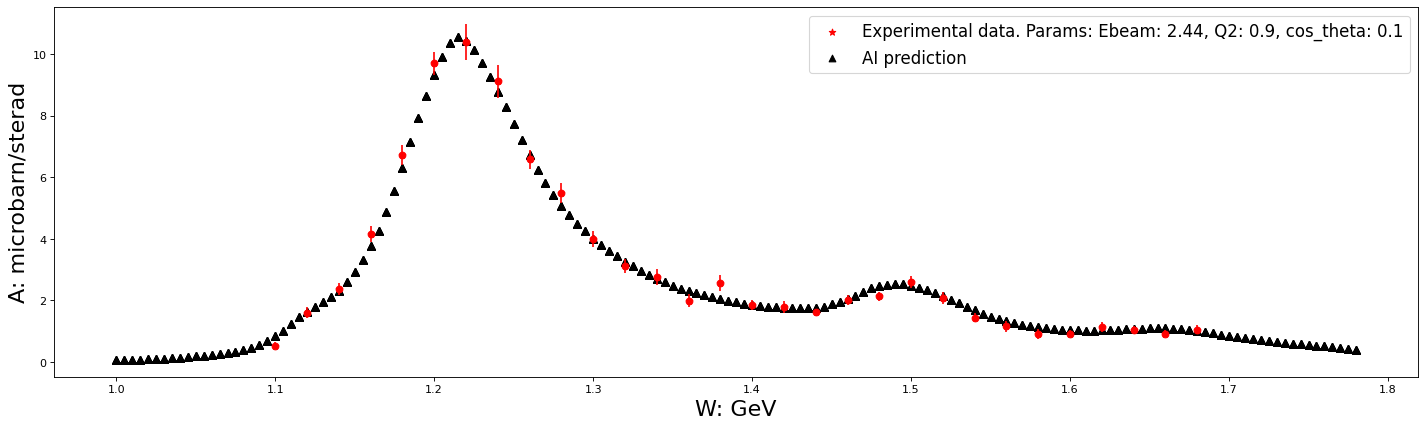

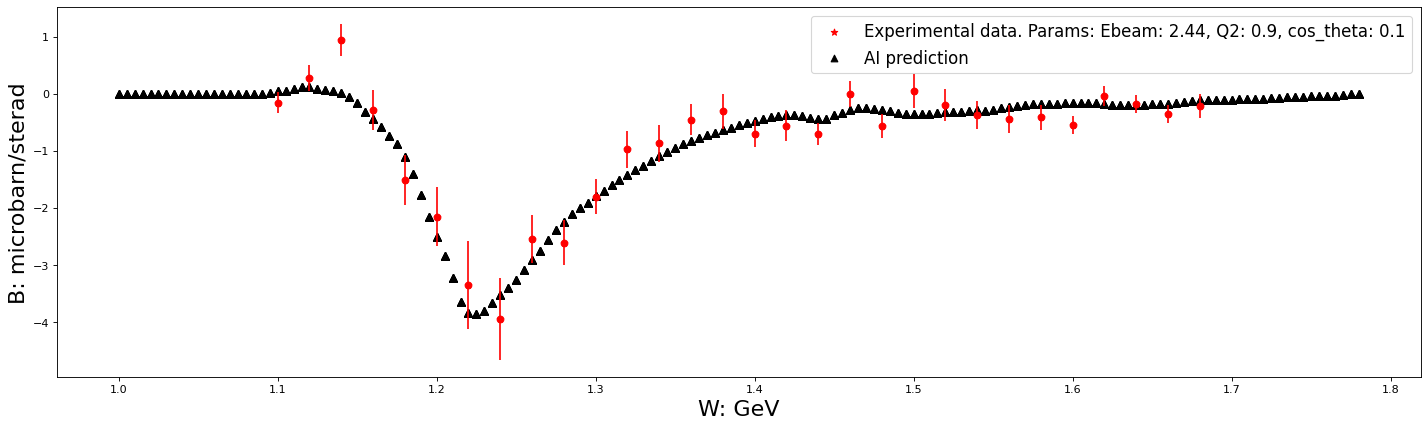

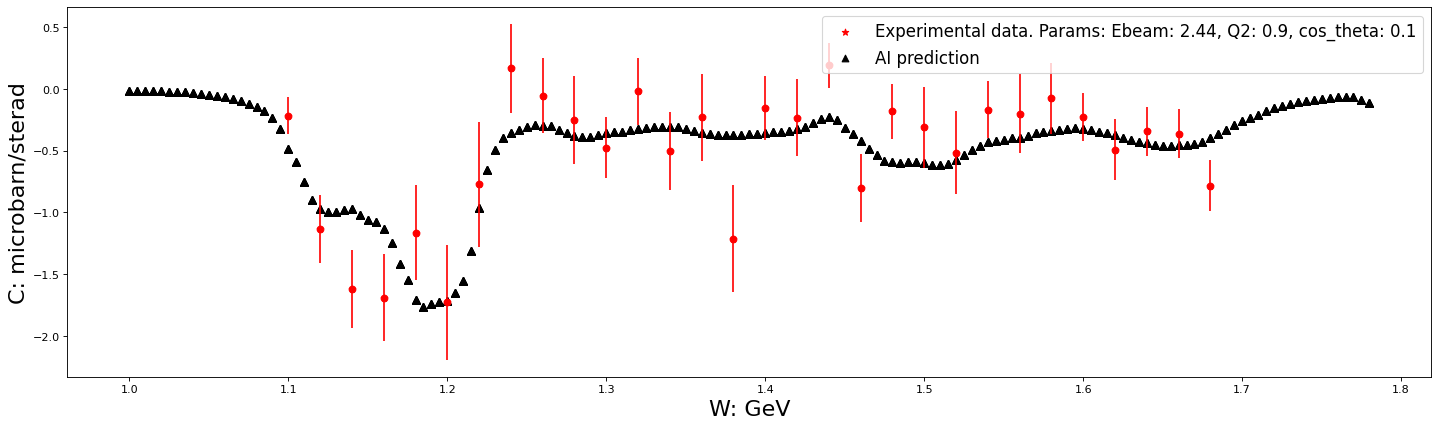

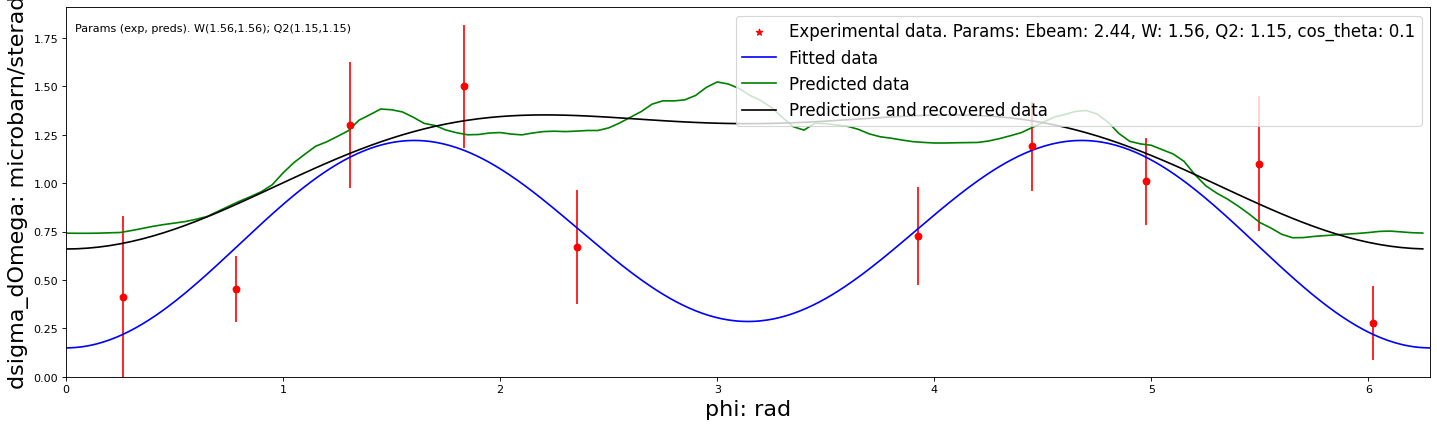

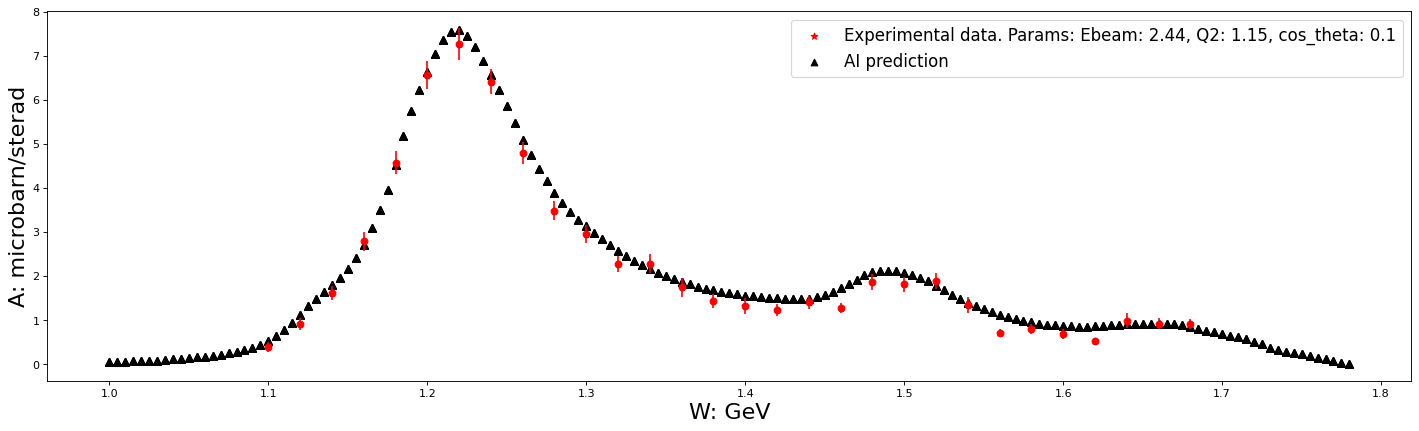

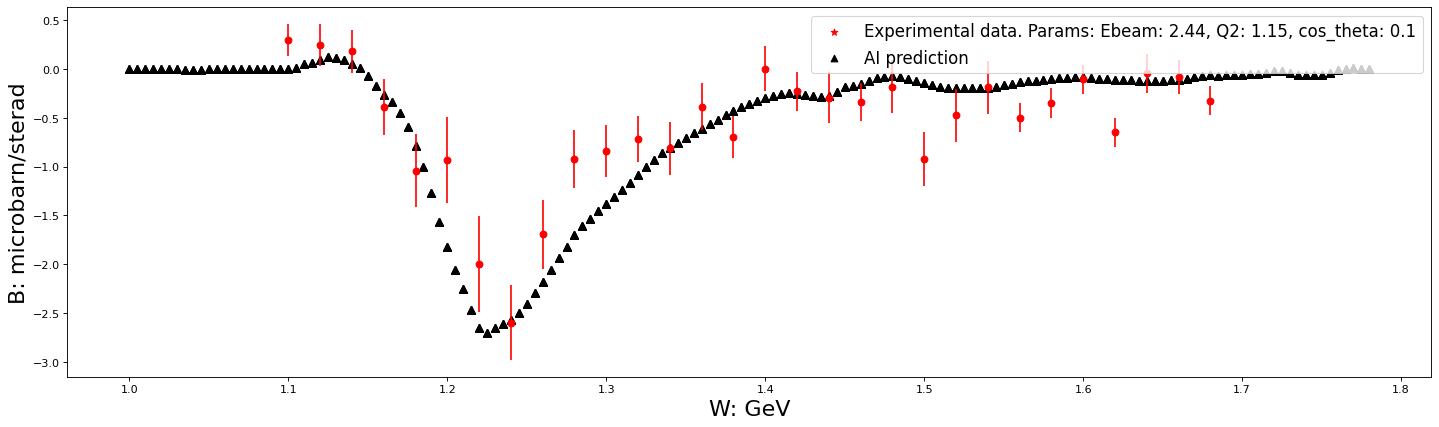

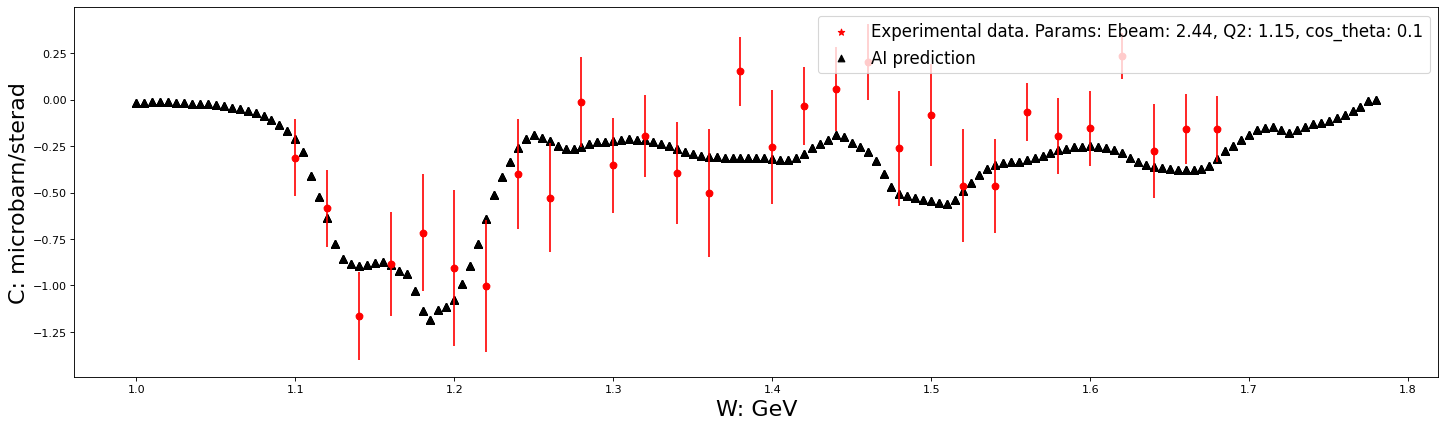

100%|██████████| 97/97 [00:08<00:00, 11.58it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.015019737766839595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0018958146723750777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

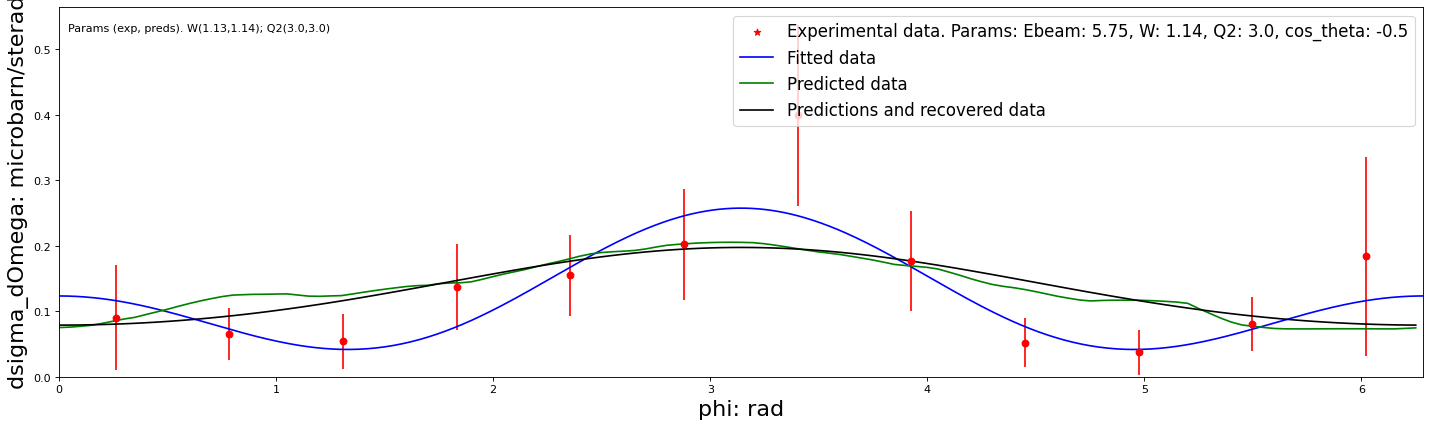

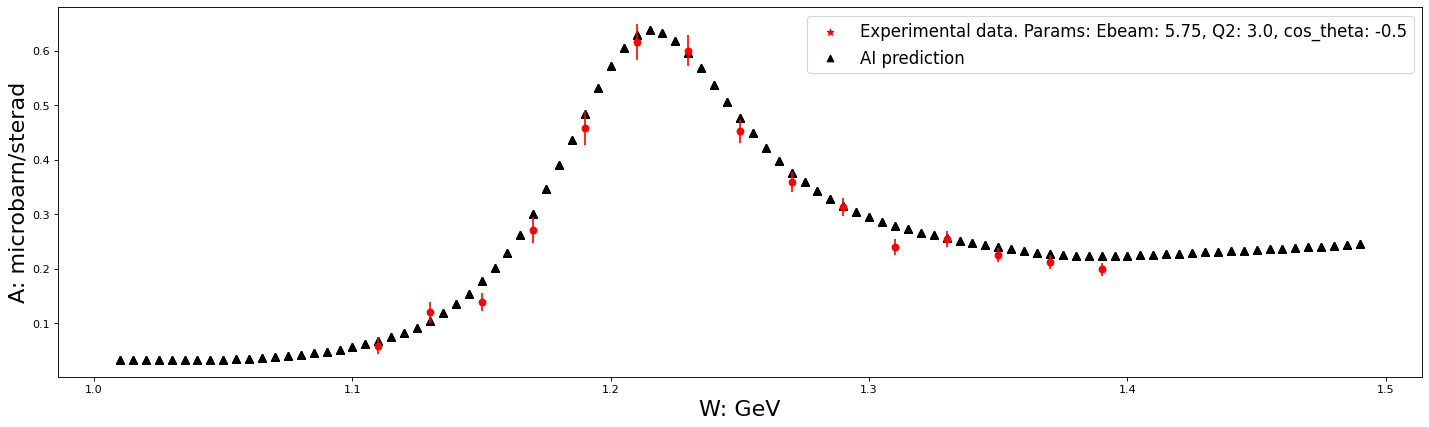

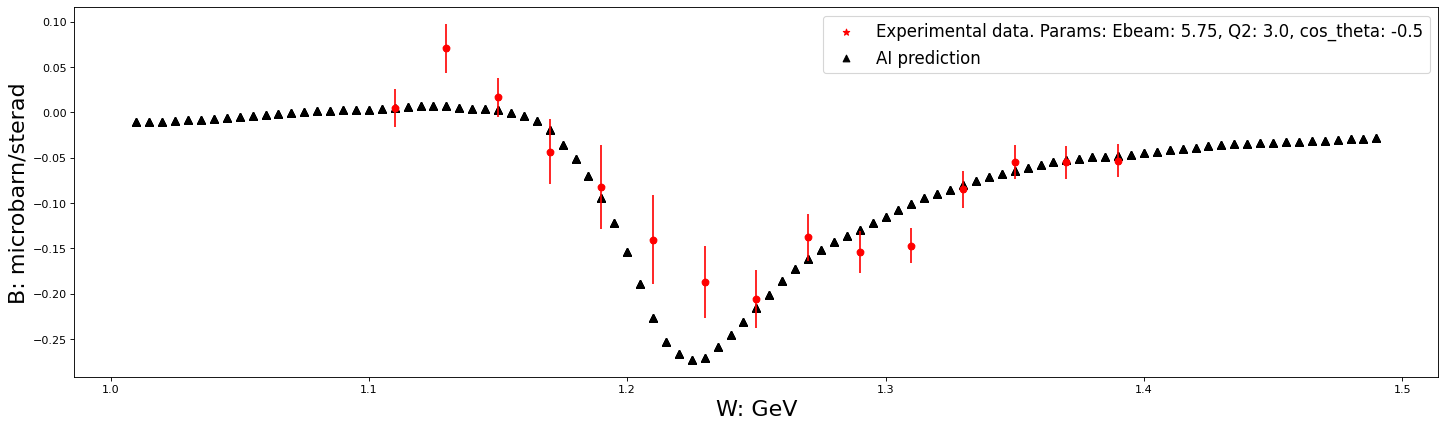

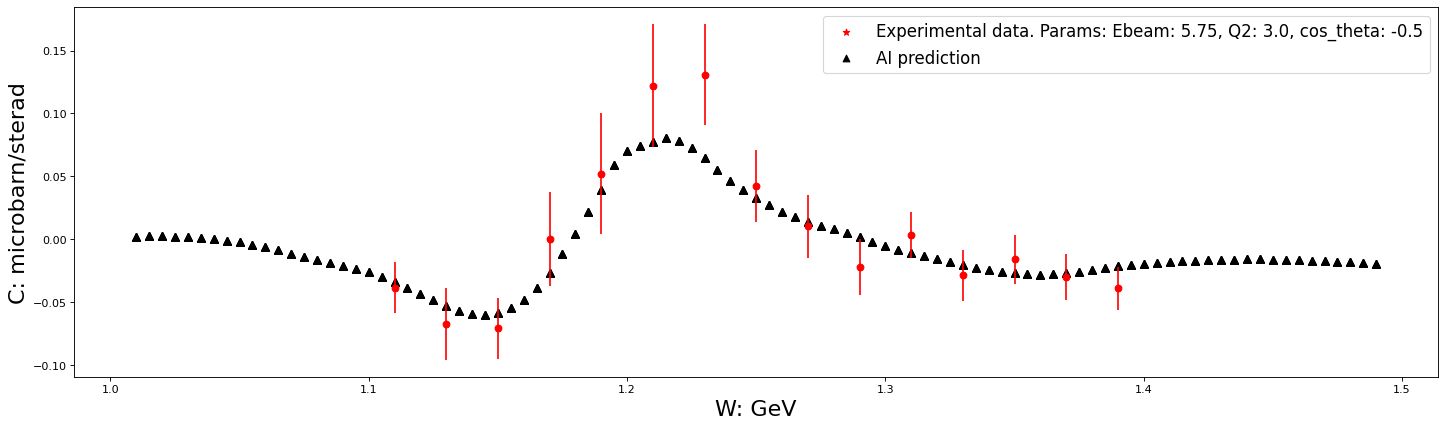

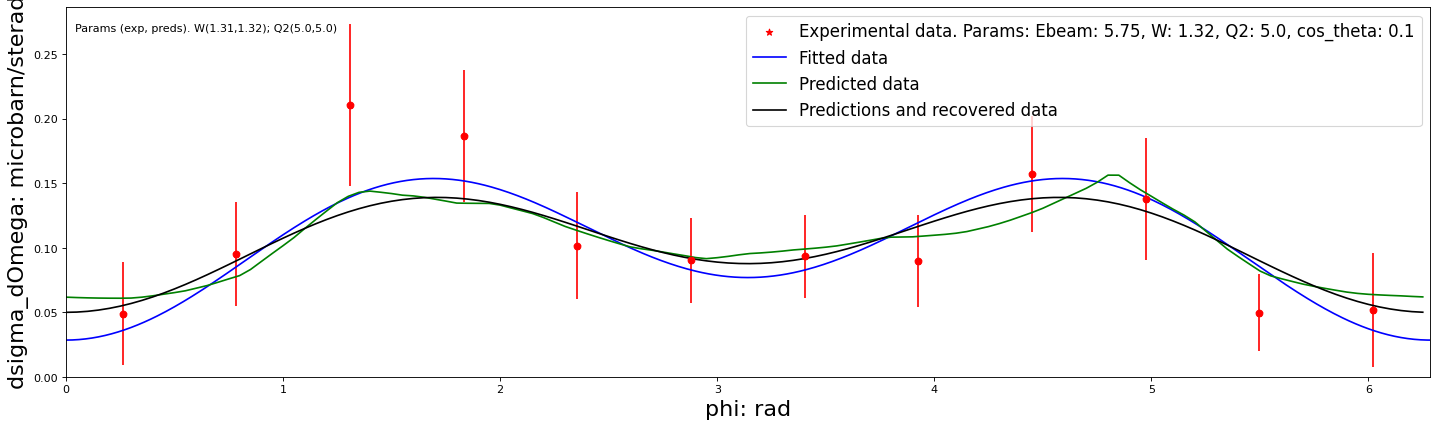

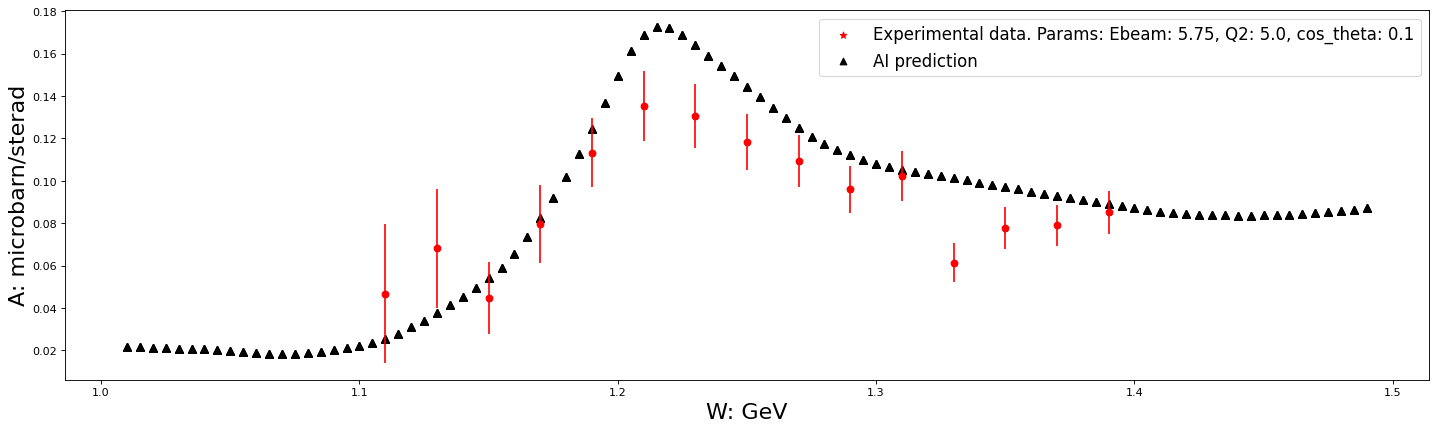

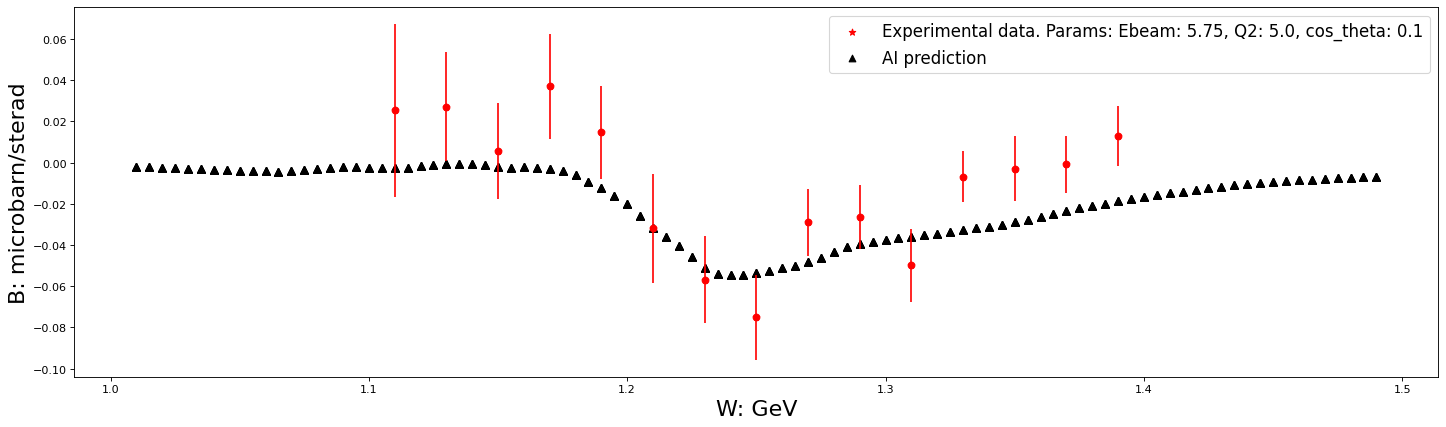

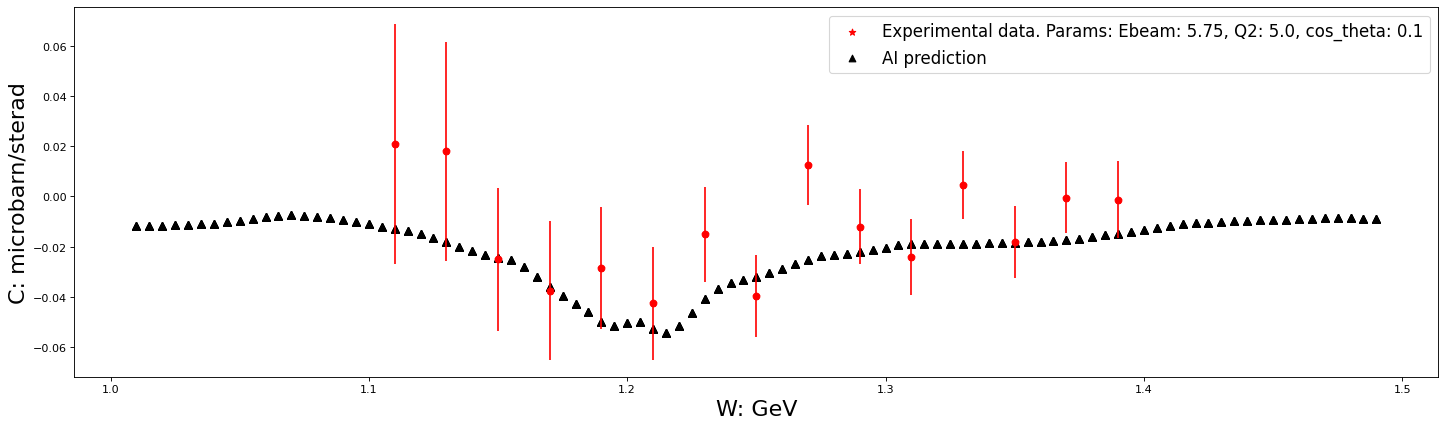

100%|██████████| 177/177 [00:05<00:00, 31.96it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06901105032026486' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.003932383940200684' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

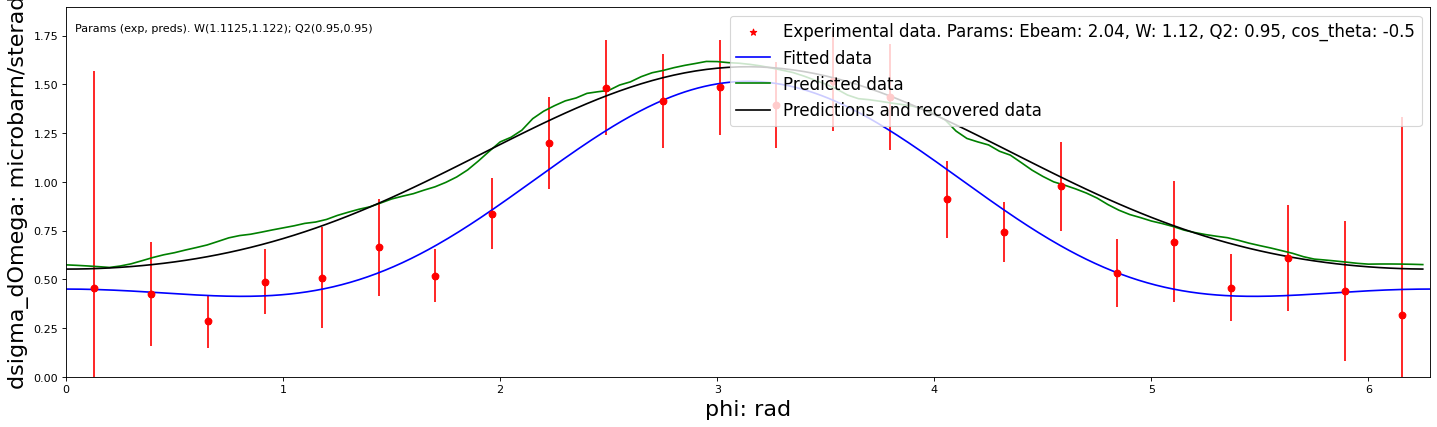

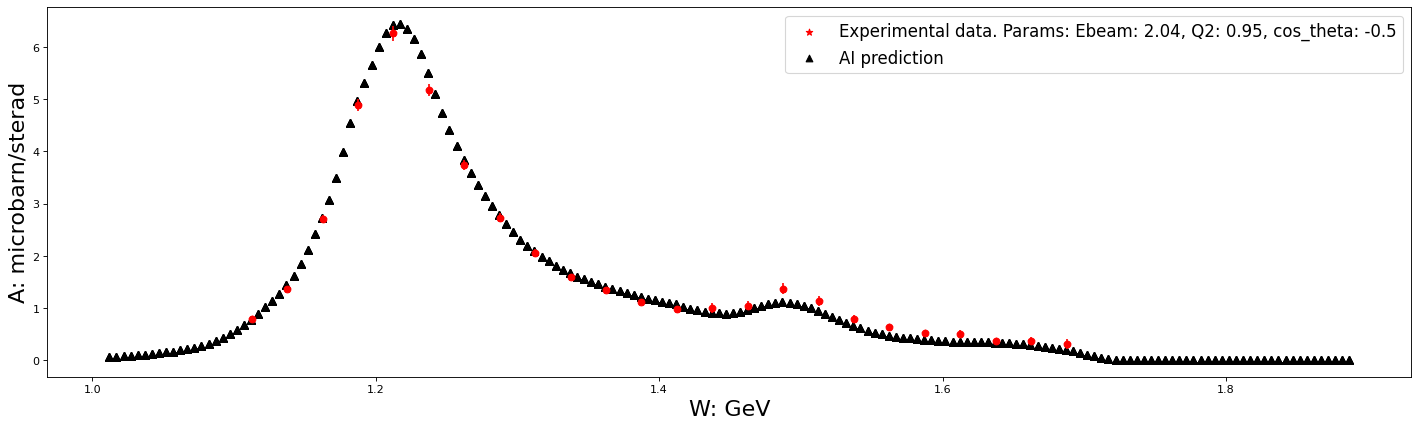

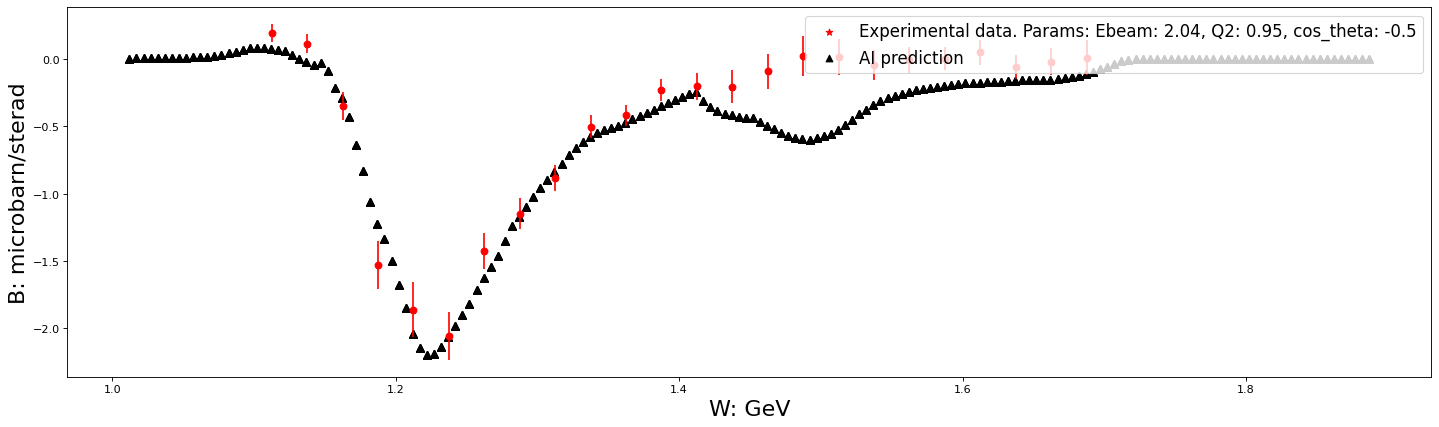

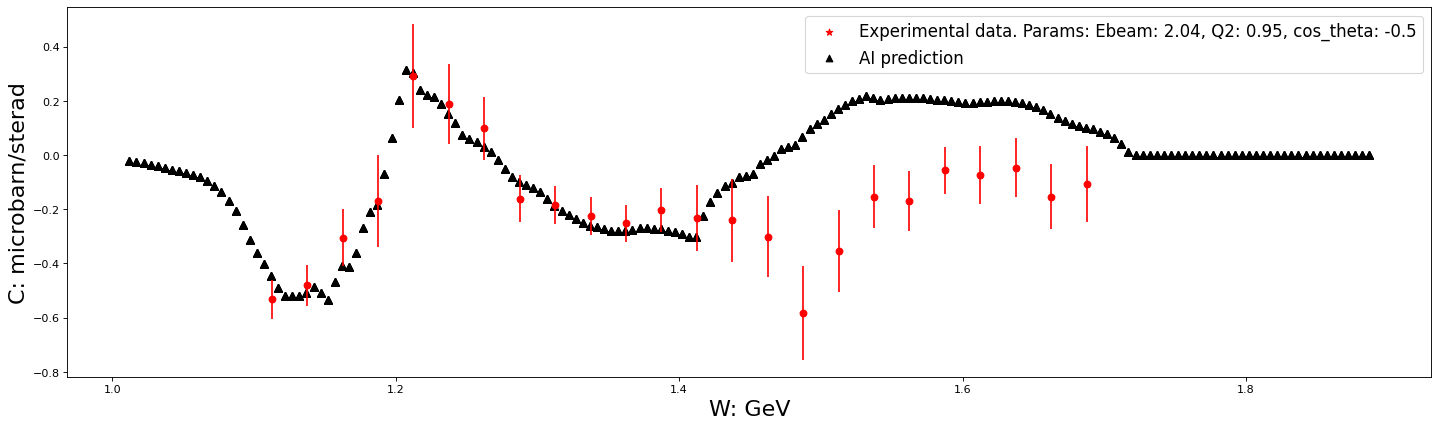

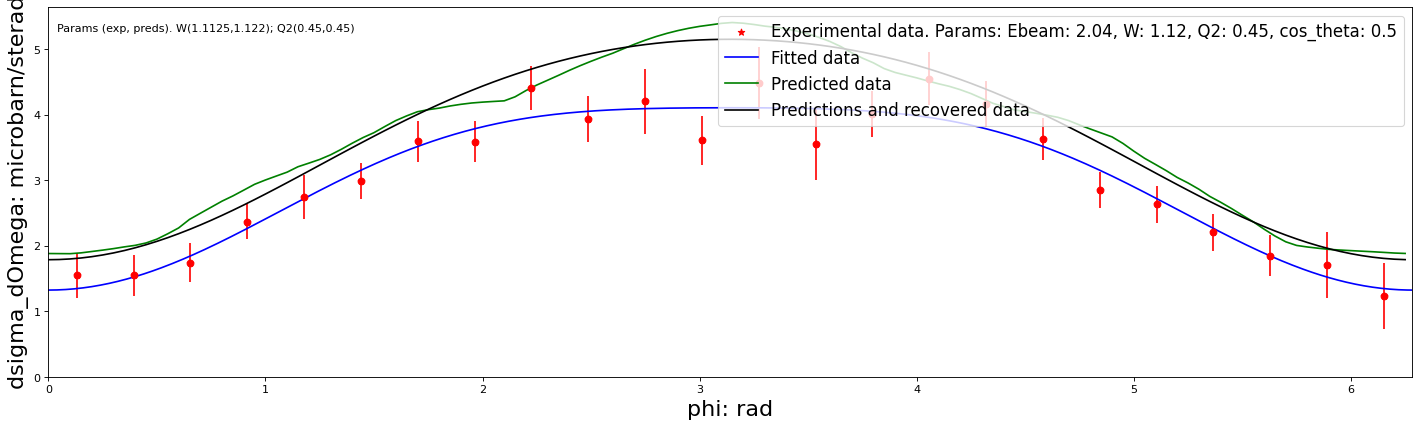

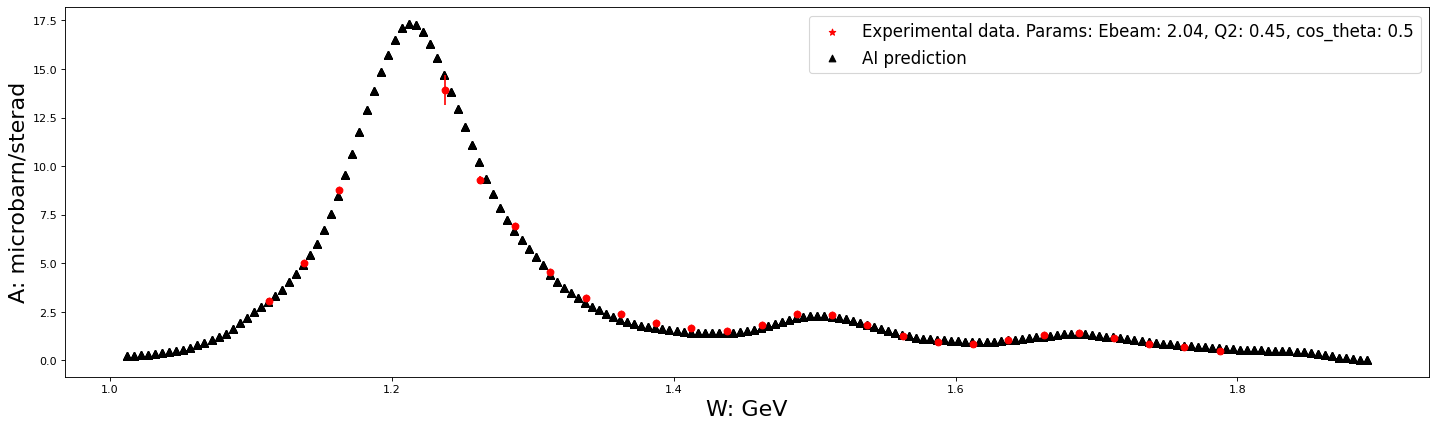

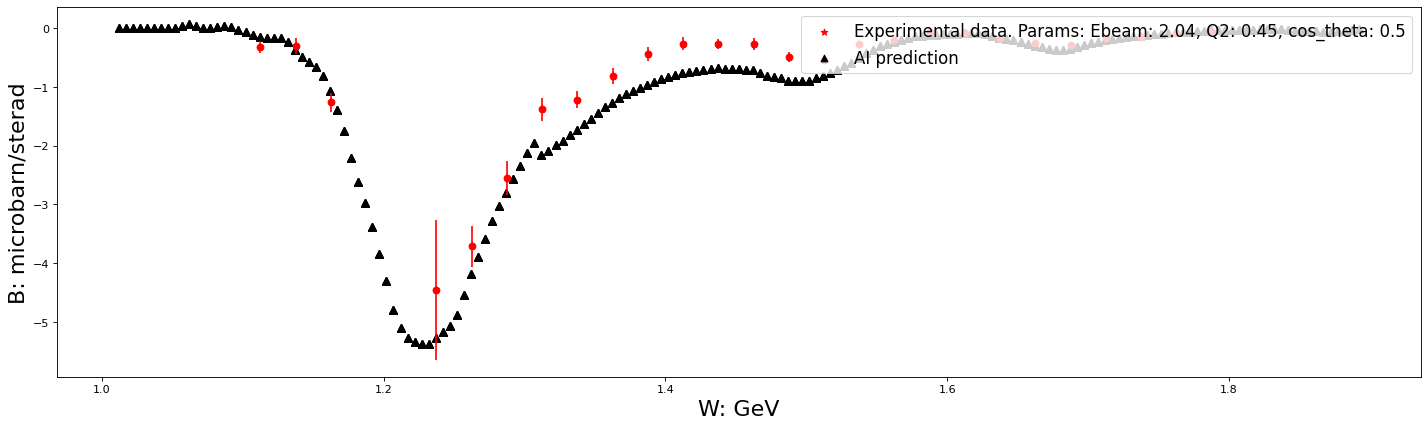

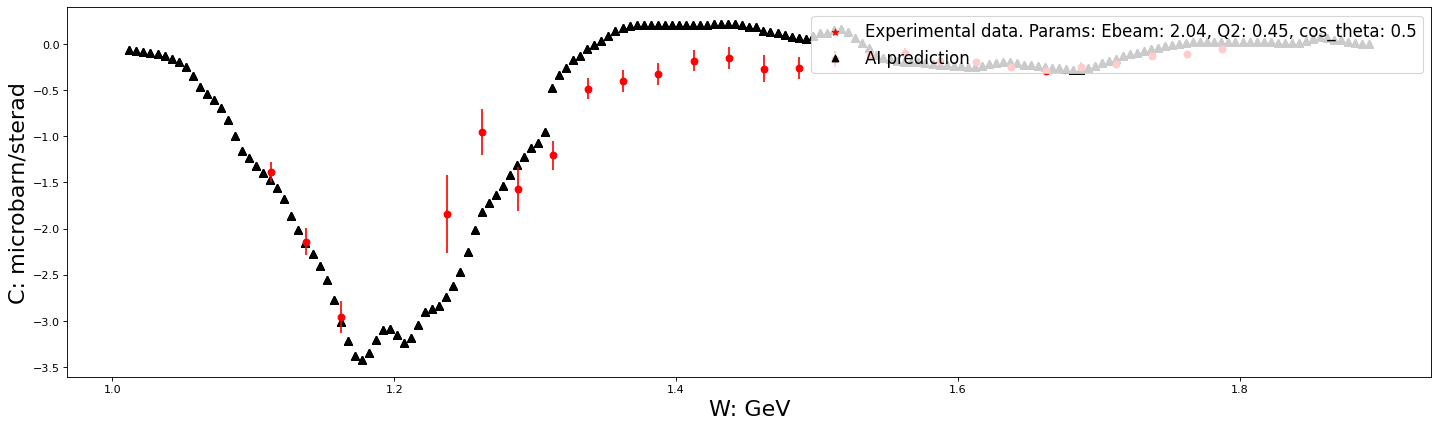

In [13]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [14]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2025-01-29 11:43:28,358 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:28,364 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:28,372 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:28,385 : DEBUG : STREAM b'IDAT' 132 65536
2025-01-29 11:43:28,432 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2025-01-29 11:43:28,503 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-01-29 11:43:28,560 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-01-29 11:43:28,581 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:28,588 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:28,592 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:28,598 : DEBUG : STREAM b'IDAT' 132 65536
2025-01-29 11:43:28,643 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:28,646 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:28,650 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:28,653 : DEBUG : STREAM b'IDAT' 132 38238
2025-01-29 11:43:28,674 : DEBUG : STREAM b'IHDR' 16 13
2

In [15]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2025-01-29 11:43:32,807 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:32,810 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:32,816 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:32,820 : DEBUG : STREAM b'IDAT' 132 65536
2025-01-29 11:43:32,883 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:32,887 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:32,892 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:32,897 : DEBUG : STREAM b'IDAT' 132 38238
2025-01-29 11:43:32,924 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:32,928 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:32,932 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:32,934 : DEBUG : STREAM b'IDAT' 132 37391
2025-01-29 11:43:32,967 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:32,974 : DEBUG : STREAM b'tEXt' 41 58
2025-01-29 11:43:32,976 : DEBUG : STREAM b'pHYs' 111 9
2025-01-29 11:43:32,981 : DEBUG : STREAM b'IDAT' 132 36609
2025-01-29 11:43:33,013 : DEBUG : STREAM b'IHDR' 16 13
2025-01-29 11:43:33,020 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [16]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,██████████▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▁▁▇████████████████████████████████████
train_rmse,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,███▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,███▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False